In [1]:
# Load required libraries
library(dplyr)
library(ggplot2)
library(readxl)
library(tidyr)
library(viridis)
library(patchwork)

# Create output directory
dir.create("APA_DE_analysis_output", showWarnings = FALSE)

# Function to process APA data
process_apa_data <- function(file_path, fdr_threshold = 1.14e-21, red_type = "REDi") {
  tryCatch({
    apa_data <- read.table(file_path, header = TRUE, sep = "\t")
    
    apa_data %>%
      filter(pval < fdr_threshold) %>%
      filter(abs(!!sym(red_type)) > 1) %>%
      filter(!!sym(paste0(red_type, ".pval")) < 0.05) %>%
      filter(!is.infinite(!!sym(red_type))) %>%
      filter(!is.na(!!sym(red_type))) %>%
      select(gene, !!sym(red_type)) %>%
      mutate(abs_RED = abs(!!sym(red_type)))
  }, error = function(e) {
    message(sprintf("Error processing APA data for file %s: %s", file_path, e$message))
    return(NULL)
  })
}

# Function to create scatter plot with p-value
create_scatter_plot <- function(merged_data, cell_type, red_type) {
  # Calculate correlation and p-value
  cor_test <- cor.test(merged_data$standardized_RED, 
                      merged_data$standardized_LogFC, 
                      method = "spearman")
  
  ggplot(merged_data, aes(x = standardized_RED, y = standardized_LogFC)) +
    geom_point(alpha = 0.6, color = "#2b8cbe") +
    geom_smooth(method = "lm", se = FALSE, color = "#e41a1c", size = 1) +
    labs(x = paste("Standardized Absolute", red_type),
         y = "Standardized Absolute LogFC",
         title = paste(cell_type, "-", red_type, "vs DE"),
         subtitle = sprintf("Spearman correlation: %.2f (p = %.2e)", 
                          cor_test$estimate,
                          cor_test$p.value)) +
    theme_minimal() +
    theme(
      plot.title = element_text(size = 14, face = "bold"),
      plot.subtitle = element_text(size = 12),
      axis.title = element_text(size = 12),
      axis.text = element_text(size = 10),
      panel.grid.minor = element_blank(),
      panel.border = element_rect(fill = NA, color = "black", size = 0.5)
    )
}

# Read DE data for C9ALS and sALS
de_data_path <- "/home/aiden/codes/APA_stuff/APA_ALS_paper_rev_2024/data/Supplementary_Data_Table2.xlsx"
c9_de <- read_excel(de_data_path, sheet = 1)
sals_de <- read_excel(de_data_path, sheet = 2)

# Rename cell types
c9_de <- c9_de %>%
  mutate(celltype = ifelse(celltype == "L23-IT", "Exc_upper", celltype)) %>%
  mutate(celltype = ifelse(celltype == "Micro-PVM", "Microglia", celltype))
sals_de <- sals_de %>%
  mutate(celltype = ifelse(celltype == "L23-IT", "Exc_upper", celltype)) %>%
  mutate(celltype = ifelse(celltype == "Micro-PVM", "Microglia", celltype))

# Get unique cell types
cell_types <- unique(c9_de$celltype)
print("Available cell types:")
print(cell_types)

# Initialize results dataframe with p-value column
results <- data.frame(
  cell_type = character(),
  condition = character(),
  red_type = character(),
  correlation = numeric(),
  p_value = numeric(),
  n_genes = numeric(),
  stringsAsFactors = FALSE
)
fdr_thresholds = c(1.800e-14, 4.768e-14, 6.595e-16, 2.819e-20, 1.140e-21, 9.021e-11, 1.230e-20, 2.820e-12)
cell_types = c("Astro", "Exc_deep", "Exc_int", "Exc_upper", "Inh", "Microglia", "Oligo", "OPC")
# Process each cell type for both C9ALS and sALS
for (cell_type in cell_types) {
  print(sprintf("Processing cell type: %s", cell_type))
  
  # Process C9ALS
  c9_de_subset <- c9_de %>%
    filter(celltype == cell_type) %>%
    select(gene, avg_log2FC) %>%
    mutate(abs_LogFC = abs(avg_log2FC))
  
  # Process sALS
  sals_de_subset <- sals_de %>%
    filter(celltype == cell_type) %>%
    select(gene, avg_log2FC) %>%
    mutate(abs_LogFC = abs(avg_log2FC))
  
  # Process both REDi and REDu
  for (red_type in c("REDi", "REDu")) {
    # Process C9ALS
    c9_apa_file <- sprintf("/data1/APA/Paul_ALS_Data/Mapper_outs_2024/%s_C9ALSvsCTRL/gene.txt", cell_type)
    c9_apa_subset <- process_apa_data(c9_apa_file, fdr_thresholds[cell_types == cell_type], red_type = red_type)
    
    # Process sALS
    sals_apa_file <- sprintf("/data1/APA/Paul_ALS_Data/Mapper_outs_2024/%s_sALSvsCTRL/gene.txt", cell_type)
    sals_apa_subset <- process_apa_data(sals_apa_file,dr_thresholds[cell_types == cell_type], red_type = red_type)
    
    # Process C9ALS data
    if (!is.null(c9_apa_subset)) {
      c9_merged <- inner_join(c9_apa_subset, c9_de_subset, by = "gene") %>%
        mutate(
          standardized_RED = scale(abs_RED),
          standardized_LogFC = scale(abs_LogFC)
        )
      
      c9_cor_test <- cor.test(c9_merged$standardized_RED, 
                             c9_merged$standardized_LogFC, 
                             method = "spearman")
      
      results <- rbind(results, data.frame(
        cell_type = cell_type,
        condition = "C9ALS",
        red_type = red_type,
        correlation = c9_cor_test$estimate,
        p_value = c9_cor_test$p.value,
        n_genes = nrow(c9_merged)
      ))
      
      # Create and save scatter plot
      c9_plot <- create_scatter_plot(c9_merged, paste0(cell_type, " C9ALS"), red_type)
      ggsave(
        sprintf("APA_DE_analysis_output/%s_C9ALS_%s_scatter.pdf", cell_type, red_type),
        c9_plot,
        width = 4,
        height = 3,
        units = "in"
      )
    }
    
    # Process sALS data
    if (!is.null(sals_apa_subset)) {
      sals_merged <- inner_join(sals_apa_subset, sals_de_subset, by = "gene") %>%
        mutate(
          standardized_RED = scale(abs_RED),
          standardized_LogFC = scale(abs_LogFC)
        )
      
      sals_cor_test <- cor.test(sals_merged$standardized_RED, 
                               sals_merged$standardized_LogFC, 
                               method = "spearman")
      
      results <- rbind(results, data.frame(
        cell_type = cell_type,
        condition = "sALS",
        red_type = red_type,
        correlation = sals_cor_test$estimate,
        p_value = sals_cor_test$p.value,
        n_genes = nrow(sals_merged)
      ))
      
      # Create and save scatter plot
      sals_plot <- create_scatter_plot(sals_merged, paste0(cell_type, " sALS"), red_type)
      ggsave(
        sprintf("APA_DE_analysis_output/%s_sALS_%s_scatter.pdf", cell_type, red_type),
        sals_plot,
        width = 4,
        height = 2,
        units = "in"
      )
    }
  }
}

# Save correlation results
write.csv(results, "APA_DE_analysis_output/correlation_results.csv", row.names = FALSE)

# Print summary of results with p-values
print("Analysis complete. Summary of correlations:")
print(results %>% 
        arrange(cell_type, condition, red_type) %>%
        mutate(p_value = format(p_value, scientific = TRUE, digits = 2)))


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite



[1] "Available cell types:"
 [1] "Astro"     "Exc_deep"  "Exc_int"   "In-LAMP5"  "In-SNCG"   "In-SST"   
 [7] "In-VIP"    "Inh"       "Exc_upper" "L4-IT"     "Microglia" "Oligo"    
[13] "OPC"      
[1] "Processing cell type: Astro"


Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Astro_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'

Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Astro_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



[1] "Processing cell type: Exc_deep"


Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Exc_deep_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'

Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Exc_deep_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



[1] "Processing cell type: Exc_int"


Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Exc_int_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'

Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Exc_int_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



[1] "Processing cell type: Exc_upper"


Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Exc_upper_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'

Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Exc_upper_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



[1] "Processing cell type: Inh"


Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Inh_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'

Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Inh_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



[1] "Processing cell type: Microglia"


Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Microglia_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'

Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Microglia_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



[1] "Processing cell type: Oligo"


Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Oligo_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'

Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/Oligo_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



[1] "Processing cell type: OPC"


Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/OPC_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'

Error processing APA data for file /data1/APA/Paul_ALS_Data/Mapper_outs_2024/OPC_sALSvsCTRL/gene.txt: Problem while computing `..1 = pval < fdr_threshold`.

Warning message in cor.test.default(c9_merged$standardized_RED, c9_merged$standardized_LogFC, :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(merged_data$standardized_RED, merged_data$standardized_LogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'



[1] "Analysis complete. Summary of correlations:"
      cell_type condition red_type  correlation p_value n_genes
rho       Astro     C9ALS     REDi -0.090831736 1.4e-01     267
rho1      Astro     C9ALS     REDu -0.130033818 9.6e-02     165
rho2   Exc_deep     C9ALS     REDi  0.056872867 3.2e-01     314
rho3   Exc_deep     C9ALS     REDu -0.095201582 1.2e-01     261
rho4    Exc_int     C9ALS     REDi  0.018694482 8.4e-01     123
rho5    Exc_int     C9ALS     REDu  0.015518201 8.8e-01      95
rho6  Exc_upper     C9ALS     REDi  0.011918397 7.3e-01     868
rho7  Exc_upper     C9ALS     REDu  0.005598604 8.8e-01     740
rho8        Inh     C9ALS     REDi  0.030719276 1.9e-01    1815
rho9        Inh     C9ALS     REDu -0.007801046 7.5e-01    1609
rho10 Microglia     C9ALS     REDi -0.119652793 9.0e-04     767
rho11 Microglia     C9ALS     REDu -0.063912935 1.2e-01     593
rho12     Oligo     C9ALS     REDi -0.100690983 1.1e-02     637
rho13     Oligo     C9ALS     REDu -0.038392424 4.7e-0

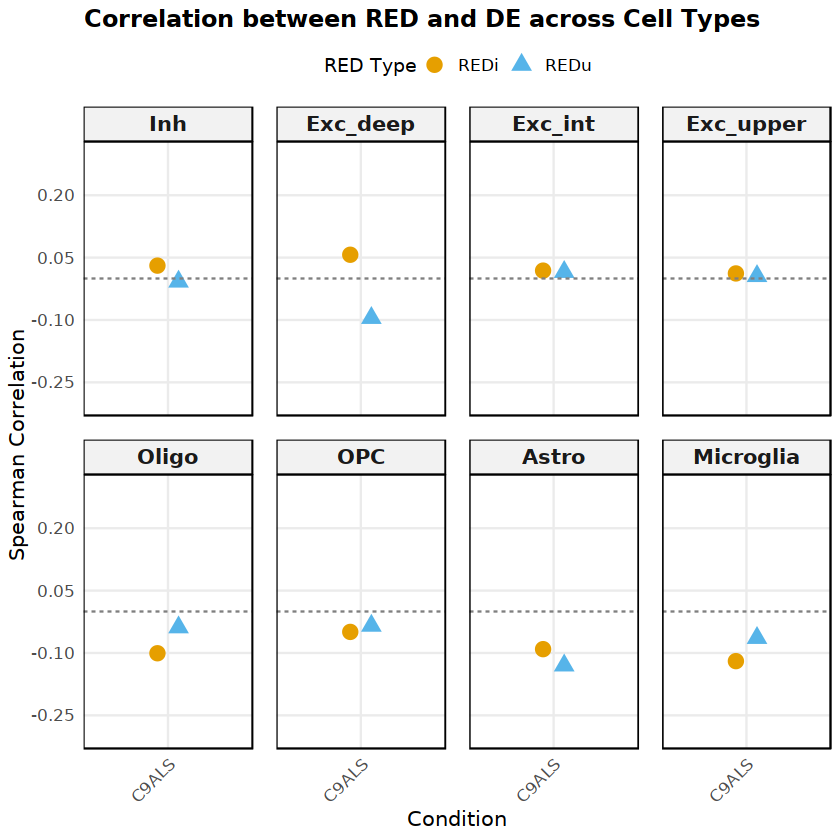

In [2]:
results$cell_type <- factor(results$cell_type, 
                          levels = c("Inh","Exc_deep", "Exc_int","Exc_upper",
                                   "Oligo", "OPC", "Astro", "Microglia"))

# Create improved faceted summary plot
ggplot(results, 
       aes(x = condition, 
           y = correlation,
           color = red_type,
           shape = red_type)) +
  geom_point(size = 4, position = position_dodge(width = 0.3)) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray50", size = 0.5) +
  facet_wrap(~cell_type, ncol = 4, drop = FALSE) +  # Removed scales="free_y"
  scale_y_continuous(limits = c(-0.3, 0.3), 
                    breaks = seq(-0.25, 0.25, 0.15)) +  # Fixed y-axis range
  scale_color_manual(name = "RED Type",
                    values = c("REDi" = "#E69F00",
                             "REDu" = "#56B4E9")) +
  scale_shape_manual(name = "RED Type",
                    values = c("REDi" = 16,
                             "REDu" = 17)) +
  labs(x = "Condition",
       y = "Spearman Correlation",
       title = "Correlation between RED and DE across Cell Types") +
  theme_minimal() +
  theme(
    strip.background = element_rect(fill = "gray95", color = "black", size = 0.5),
    strip.text = element_text(size = 12, face = "bold"),
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    plot.title = element_text(size = 14, face = "bold"),
    legend.position = "top",
    legend.text = element_text(size = 10),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(fill = NA, color = "black", size = 0.5),
    panel.spacing = unit(1, "lines")
  )

ggsave("APA_DE_analysis_output/correlation_summary_scatter.pdf",
       width = 8,
       height = 4,
       units = "in")


In [3]:
# Process the data for Exc_upper sALS REDu
sALS_apa <- read.table('/data1/APA/Paul_ALS_Data/Mapper_outs_2024/Exc_upper_sALSvsCTRL/gene.txt', header = T, sep = "\t")
#
sALS_apa <- sALS_apa %>% filter(gene!="FKBP5")

# Filter APA data
sALS_apa <- sALS_apa %>% 
  filter(pval < 1.14e-21) %>%
  filter(REDu > 1 | REDu < -1) %>% 
  filter(REDu.pval < 0.05) %>%
  filter(!is.infinite(REDu)) %>% 
  filter(!is.na(REDu)) %>%
  select(gene, REDu) %>%
  mutate(absREDu = abs(REDu))

# Get DE data
sALS_de <- read_excel('/home/aiden/codes/APA_stuff/APA_ALS_paper_rev_2024/data/Supplementary_Data_Table2.xlsx', sheet = 2)
sALS_de <- sALS_de %>%
  mutate(celltype = ifelse(celltype == "L23-IT", "Exc_upper", celltype))

s_exc_upper <- sALS_de %>%
  filter(celltype == 'Exc_upper') %>%
  select(gene, avg_log2FC) %>%
  mutate(absLogFC = abs(avg_log2FC))

# Merge and standardize
merged_df <- inner_join(sALS_apa, s_exc_upper, by = "gene") %>%
  mutate(
    standardizedREDu = scale(absREDu),
    standardizedLogFC = scale(absLogFC)
  )

# Calculate correlation and p-value
cor_test <- cor.test(merged_df$standardizedREDu, 
                     merged_df$standardizedLogFC, 
                     method = "spearman")

# Create plot with fixed axes
plot <- ggplot(merged_df, aes(x = standardizedREDu, y = standardizedLogFC)) +
  geom_point(alpha = 0.6, color = "#2b8cbe") +
  geom_smooth(method = "lm", se = FALSE, color = "#e41a1c", size = 1) +
  coord_cartesian(xlim = c(-2, 8), ylim = c(-2, 8)) +  # Adjusted limits
  labs(x = "Standardized Absolute REDu",
       y = "Standardized Absolute LogFC",
       title = "Exc_upper sALS - REDu vs DE",
       subtitle = sprintf("Spearman correlation: %.2f (p = %.2e)", 
                         cor_test$estimate,
                         cor_test$p.value)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(fill = NA, color = "black", size = 0.5)
  )

# Save the plot
ggsave("APA_DE_analysis_output/Exc_upper_sALS_REDu_scatter_fixed.pdf", plot, width = 4, height = 3, units = "in")

# Print extreme values for inspection
cat("\nExtreme values in the data:\n")
merged_df %>%
  filter(abs(standardizedREDu) > 8 | abs(standardizedLogFC) > 8) %>%
  select(gene, standardizedREDu, standardizedLogFC) %>%
  print()

# Print correlation details
cat("\nCorrelation statistics:\n")
cat(sprintf("Correlation coefficient: %.4f\n", cor_test$estimate))
cat(sprintf("P-value: %.2e\n", cor_test$p.value))
cat(sprintf("Number of genes: %d\n", nrow(merged_df)))

Warning message in cor.test.default(merged_df$standardizedREDu, merged_df$standardizedLogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'




Extreme values in the data:
[1] gene              standardizedREDu  standardizedLogFC
<0 rows> (or 0-length row.names)

Correlation statistics:
Correlation coefficient: 0.0086
P-value: 7.73e-01
Number of genes: 1125


In [4]:
# Process the data for Exc_upper sALS REDu
sALS_apa <- read.table('/data1/APA/Paul_ALS_Data/Mapper_outs_2024/Exc_upper_sALSvsCTRL/gene.txt', header = T, sep = "\t")
#
sALS_apa <- sALS_apa %>% filter(gene!="FKBP5")

# Filter APA data
sALS_apa <- sALS_apa %>% 
  filter(pval < 1.14e-21) %>%
  filter(REDi > 1 | REDi < -1) %>% 
  filter(REDi < 0.05) %>%
  filter(!is.infinite(REDi)) %>% 
  filter(!is.na(REDi)) %>%
  select(gene, REDi) %>%
  mutate(absREDu = abs(REDi))

# Get DE data
sALS_de <- read_excel('/home/aiden/codes/APA_stuff/APA_ALS_paper_rev_2024/data/Supplementary_Data_Table2.xlsx', sheet = 2)
sALS_de <- sALS_de %>%
  mutate(celltype = ifelse(celltype == "L23-IT", "Exc_upper", celltype))

s_exc_upper <- sALS_de %>%
  filter(celltype == 'Exc_upper') %>%
  select(gene, avg_log2FC) %>%
  mutate(absLogFC = abs(avg_log2FC))

# Merge and standardize
merged_df <- inner_join(sALS_apa, s_exc_upper, by = "gene") %>%
  mutate(
    standardizedREDu = scale(absREDu),
    standardizedLogFC = scale(absLogFC)
  )

# Calculate correlation and p-value
cor_test <- cor.test(merged_df$standardizedREDu, 
                     merged_df$standardizedLogFC, 
                     method = "spearman")

# Create plot with fixed axes
plot <- ggplot(merged_df, aes(x = standardizedREDu, y = standardizedLogFC)) +
  geom_point(alpha = 0.6, color = "#2b8cbe") +
  geom_smooth(method = "lm", se = FALSE, color = "#e41a1c", size = 1) +
  coord_cartesian(xlim = c(-2, 8), ylim = c(-2, 8)) +  # Adjusted limits
  labs(x = "Standardized Absolute REDu",
       y = "Standardized Absolute LogFC",
       title = "Exc_upper sALS - REDu vs DE",
       subtitle = sprintf("Spearman correlation: %.2f (p = %.2e)", 
                         cor_test$estimate,
                         cor_test$p.value)) +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    plot.subtitle = element_text(size = 12),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(fill = NA, color = "black", size = 0.5)
  )

# Save the plot
ggsave("APA_DE_analysis_output/Exc_upper_sALS_REDi_scatter_fixed.pdf", plot, width = 4, height = 3, units = "in")

# Print extreme values for inspection
cat("\nExtreme values in the data:\n")
merged_df %>%
  filter(abs(standardizedREDu) > 8 | abs(standardizedLogFC) > 8) %>%
  select(gene, standardizedREDu, standardizedLogFC) %>%
  print()

# Print correlation details
cat("\nCorrelation statistics:\n")
cat(sprintf("Correlation coefficient: %.4f\n", cor_test$estimate))
cat(sprintf("P-value: %.2e\n", cor_test$p.value))
cat(sprintf("Number of genes: %d\n", nrow(merged_df)))

Warning message in cor.test.default(merged_df$standardizedREDu, merged_df$standardizedLogFC, :
“Cannot compute exact p-value with ties”
`geom_smooth()` using formula 'y ~ x'




Extreme values in the data:
[1] gene              standardizedREDu  standardizedLogFC
<0 rows> (or 0-length row.names)

Correlation statistics:
Correlation coefficient: -0.0452
P-value: 3.36e-01
Number of genes: 455
